
# Mobile Price Range Prediction
This notebook contains the workflow for predicting the price range of mobile devices based on their features using XGBoost. We will cover the following steps:
1. Data Preprocessing
2. Model Training
3. Model Evaluation
4. Hyperparameter Tuning
5. Feature Engineering and Selection
6. Advanced Model Evaluation
7. Model Explainability
8. Pipeline Creation


In [19]:
%pip install shap
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import shap

In [21]:
# Load the dataset
df = pd.read_csv('C:/Users/assem/Desktop/Creativia Alexandria Hub/Session_05/Train.csv')

# Display basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             1995 non-null   float64
 5   four_g         1995 non-null   float64
 6   int_memory     1995 non-null   float64
 7   m_dep          1995 non-null   float64
 8   mobile_wt      1996 non-null   float64
 9   n_cores        1996 non-null   float64
 10  pc             1995 non-null   float64
 11  px_height      1996 non-null   float64
 12  px_width       1998 non-null   float64
 13  ram            1998 non-null   float64
 14  sc_h           1999 non-null   float64
 15  sc_w           1999 non-null   float64
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,...,20.0,756.0,2549.0,9.0,7.0,19,0,0,1,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,...,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0,2
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,...,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0,2
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,...,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0,2
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,...,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0,1


- Numerical Features: battery_power, clock_speed, fc (front camera megapixels), int_memory (internal memory in GB), etc.
- Categorical/Binary Features: blue (Bluetooth on/off), dual_sim (dual SIM on/off), three_g, four_g, touch_screen, etc.
- Target Variable: price_range, which classify phones into different price categories.  
  
Missing Values: Some columns have missing values, like fc, four_g, int_memory, mobile_wt, etc.

In [22]:
# Check for missing values
df.isnull().sum()

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Verify missing values are handled
df_imputed.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [23]:
# Create new feature: Screen Resolution
df_imputed['screen_resolution'] = df_imputed['px_width'] * df_imputed['px_height']
df_imputed.drop(['px_width', 'px_height'], axis=1, inplace=True)

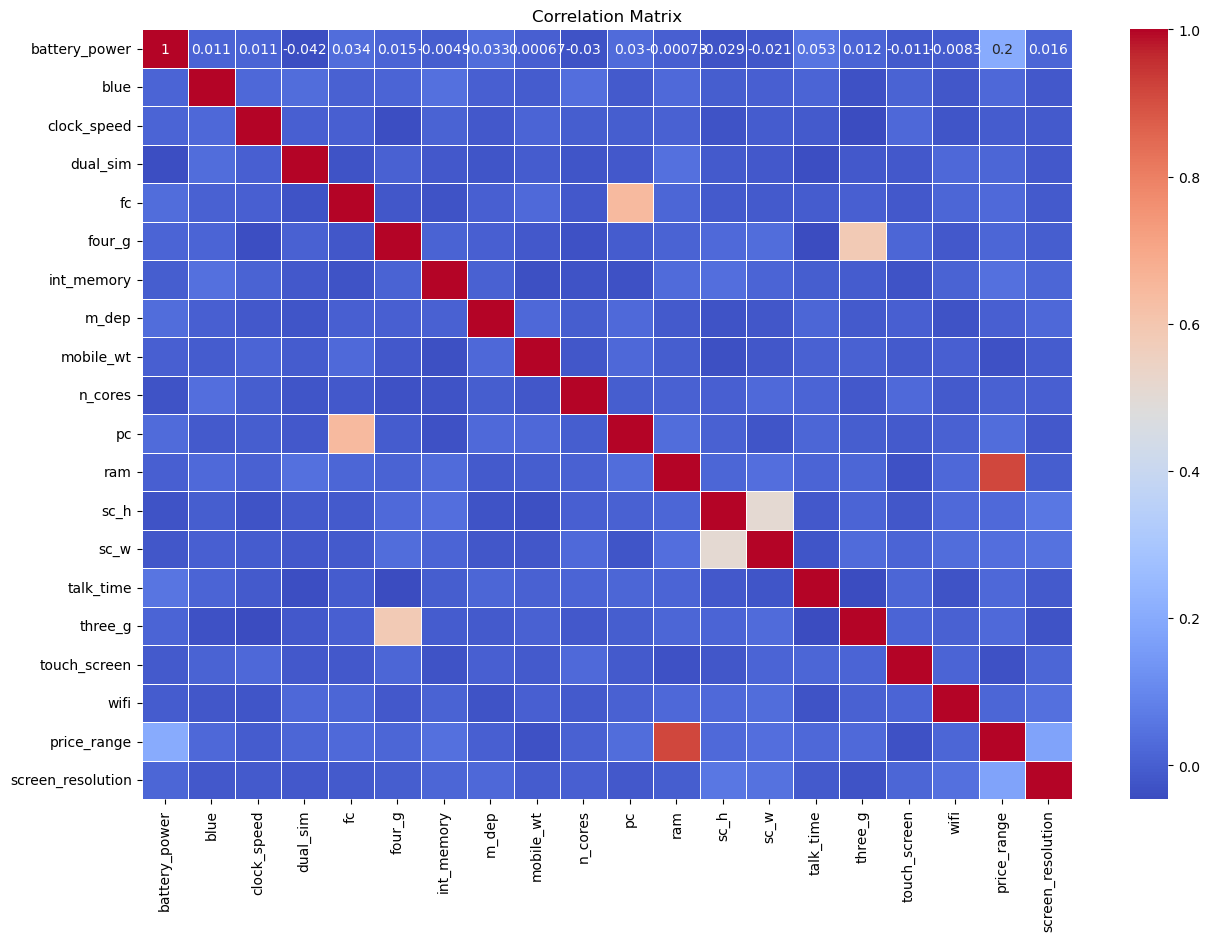

price_range          1.000000
ram                  0.917017
battery_power        0.200723
screen_resolution    0.175721
int_memory           0.042527
sc_w                 0.038814
pc                   0.034598
fc                   0.024893
three_g              0.023611
sc_h                 0.023315
talk_time            0.021859
blue                 0.020573
wifi                 0.018785
dual_sim             0.017444
four_g               0.015668
n_cores              0.004695
m_dep               -0.000078
clock_speed         -0.006606
touch_screen        -0.030411
mobile_wt           -0.032433
Name: price_range, dtype: float64

In [24]:
# Correlation matrix to see relationships between numerical features
plt.figure(figsize=(15, 10))
corr_matrix = df_imputed.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

corr_matrix = df_imputed.corr()['price_range'].sort_values(ascending=False)
corr_matrix

Key Features Affecting Price Range:
- RAM (Correlation: 0.918): The most significant feature positively correlated with the price range. Devices with higher RAM are typically more expensive.
- Battery Power (Correlation: 0.200): Shows a moderate positive relationship with price range. Higher battery capacity tends to be associated with higher-end devices.
- Pixel Width and Height (Correlation: 0.164 and 0.146): These are moderately correlated, indicating that screen resolution contributes somewhat to the price, but not as strongly as RAM.  
  
Lesser-Impact Features:
- Internal Memory (Correlation: 0.041): Has a minor positive influence, suggesting that storage alone is not a strong determinant of price.
- Screen Dimensions (Width: 0.038, Height: 0.021): Screen size has a negligible impact on price.
- Primary and Front Camera (Correlation: 0.036 and 0.025): Camera resolution has a minor role in determining the price range.
- 3G and 4G Support (Correlation: 0.023 and 0.014): Network support has minimal influence, likely because most devices in this dataset support these features.  
  
Negatively Correlated Features:
- Touch Screen (Correlation: -0.031): A small negative correlation suggests that touch screen support alone doesn’t drive higher prices.
- Mobile Weight (Correlation: -0.032): Indicates that heavier devices are slightly associated with lower price ranges.  
  
Uncorrelated or Weakly Correlated Features:
- Features like the number of cores, clock speed, depth, and dual SIM support show almost no correlation with the price range.  
  
Visual Distribution Insight:
- Features like RAM and battery power are more skewed toward higher values in pricier devices, while features like weight, screen size, and internal memory might be more evenly distributed across price ranges.

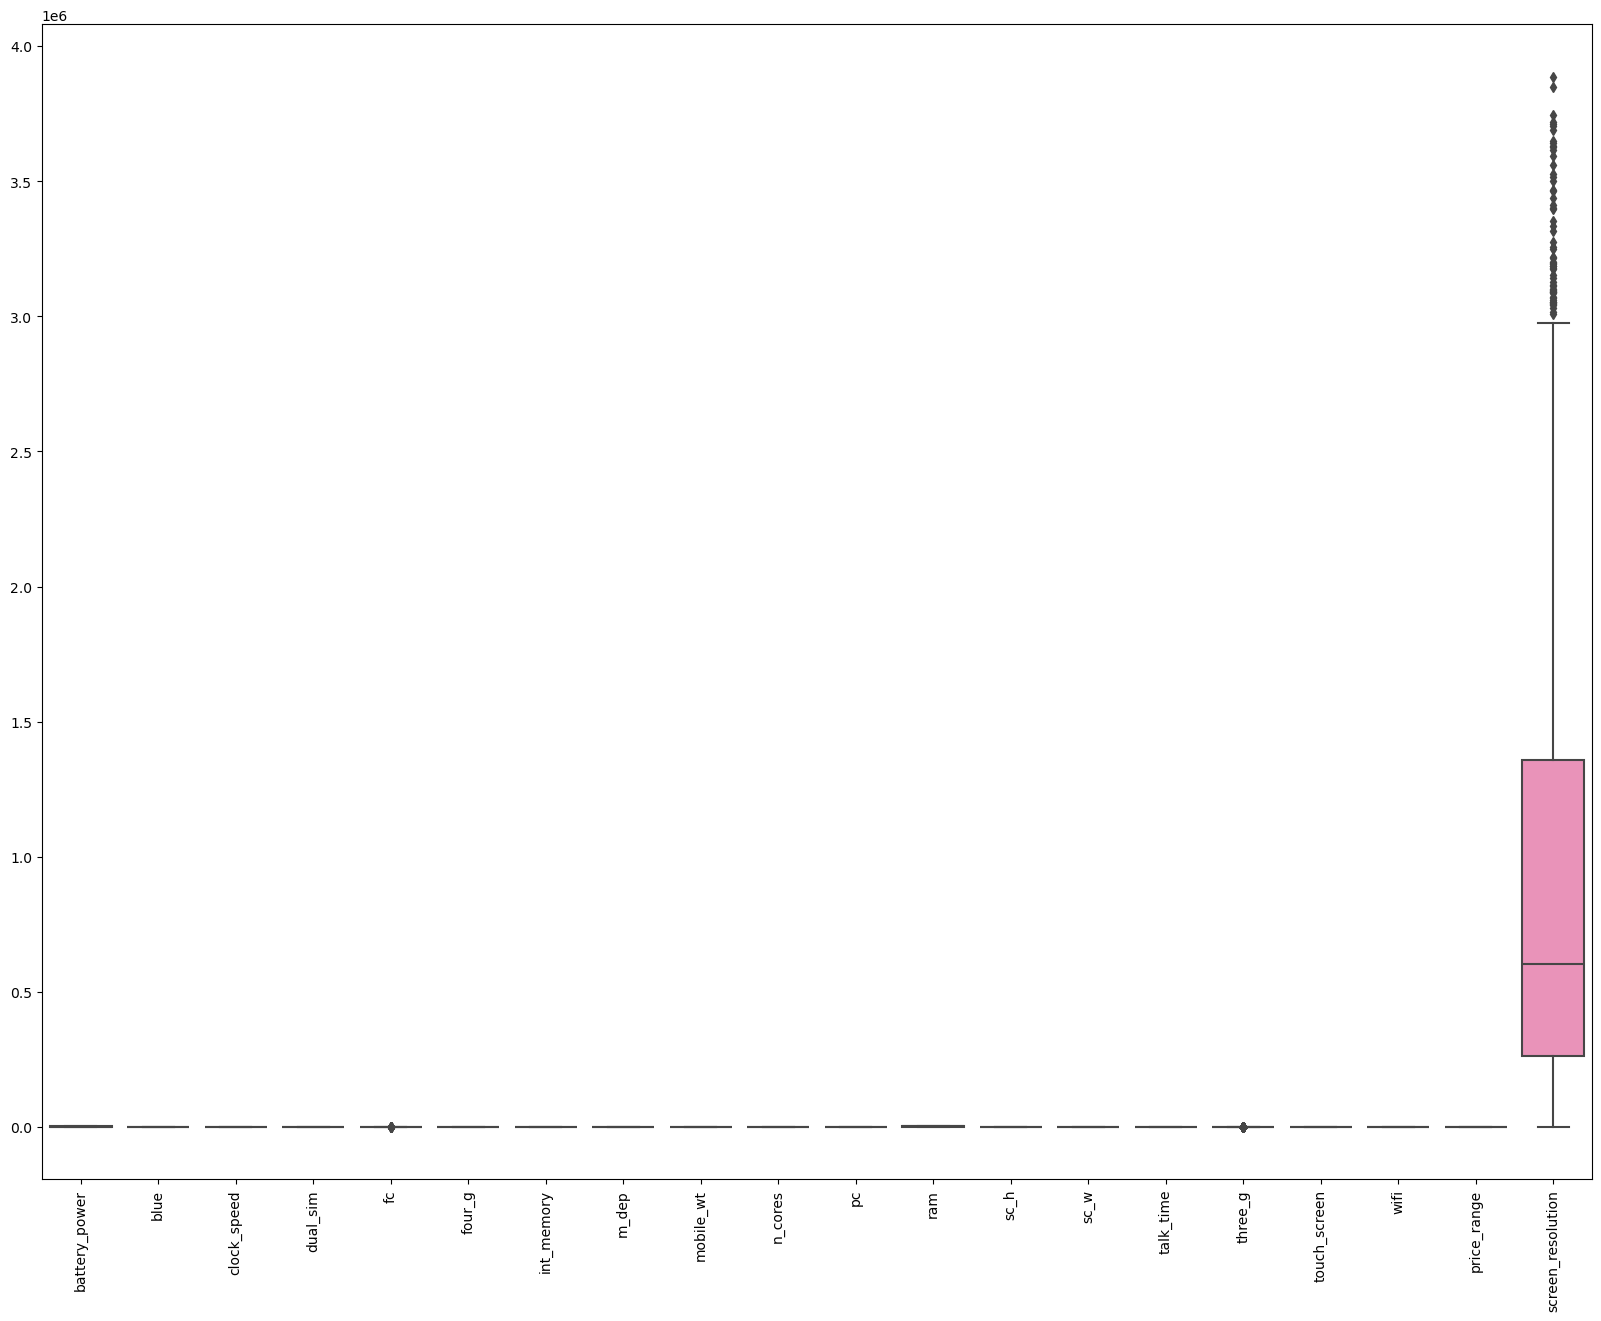

In [25]:
# Select specific columns for analysis
columns_to_analyze = df_imputed.columns

# Plot box plots for all numerical columns
plt.figure(figsize=(20, 15))
sns.boxplot(data=df_imputed[columns_to_analyze])
plt.xticks(rotation=90)
plt.show()

In [36]:
# Nomralization

# Select the features you want to normalize
features_to_normalize = ['battery_power', 'clock_speed', 'int_memory', 'm_dep', 'fc' , 'mobile_wt', 'n_cores', 'pc', 'ram', 'sc_h', 'sc_w', 'talk_time', 'screen_resolution']

# 1. Min-Max Scaling
min_max_scaler = MinMaxScaler()
df_imputed[features_to_normalize] = min_max_scaler.fit_transform(df_imputed[features_to_normalize])

# 2. Z-Score Standardization
standard_scaler = StandardScaler()
df_imputed[features_to_normalize] = standard_scaler.fit_transform(df_imputed[features_to_normalize])

print(df_imputed.head())

   battery_power  blue  clock_speed  dual_sim        fc  four_g  int_memory  \
0      -0.902597   0.0     0.830779       0.0 -0.763785     0.0   -1.382398   
1      -0.495139   1.0    -1.253064       1.0 -0.994745     1.0    1.156340   
2      -1.537686   1.0    -1.253064       1.0 -0.532825     1.0    0.494061   
3      -1.419319   1.0     1.198517       0.0 -0.994745     0.0   -1.216828   
4       1.325906   1.0    -0.395011       0.0  2.007736     1.0    0.659630   

      m_dep  mobile_wt   n_cores        pc       ram      sc_h      sc_w  \
0  0.339295   1.350634 -1.100953 -1.308565  0.391637 -0.784629  0.283336   
1  0.686401  -0.120768 -0.663546 -0.647340  0.467251  1.115486 -0.635095   
2  1.380611   0.133898  0.211268 -0.647340  0.441431 -0.309600 -0.864703   
3  1.033506  -0.262249  0.648675 -0.151421  0.594503  0.877972  0.512944   
4  0.339295   0.020713 -1.100953  0.675111 -0.657734 -1.022143 -0.864703   

   talk_time  three_g  touch_screen  wifi  price_range  screen_resol

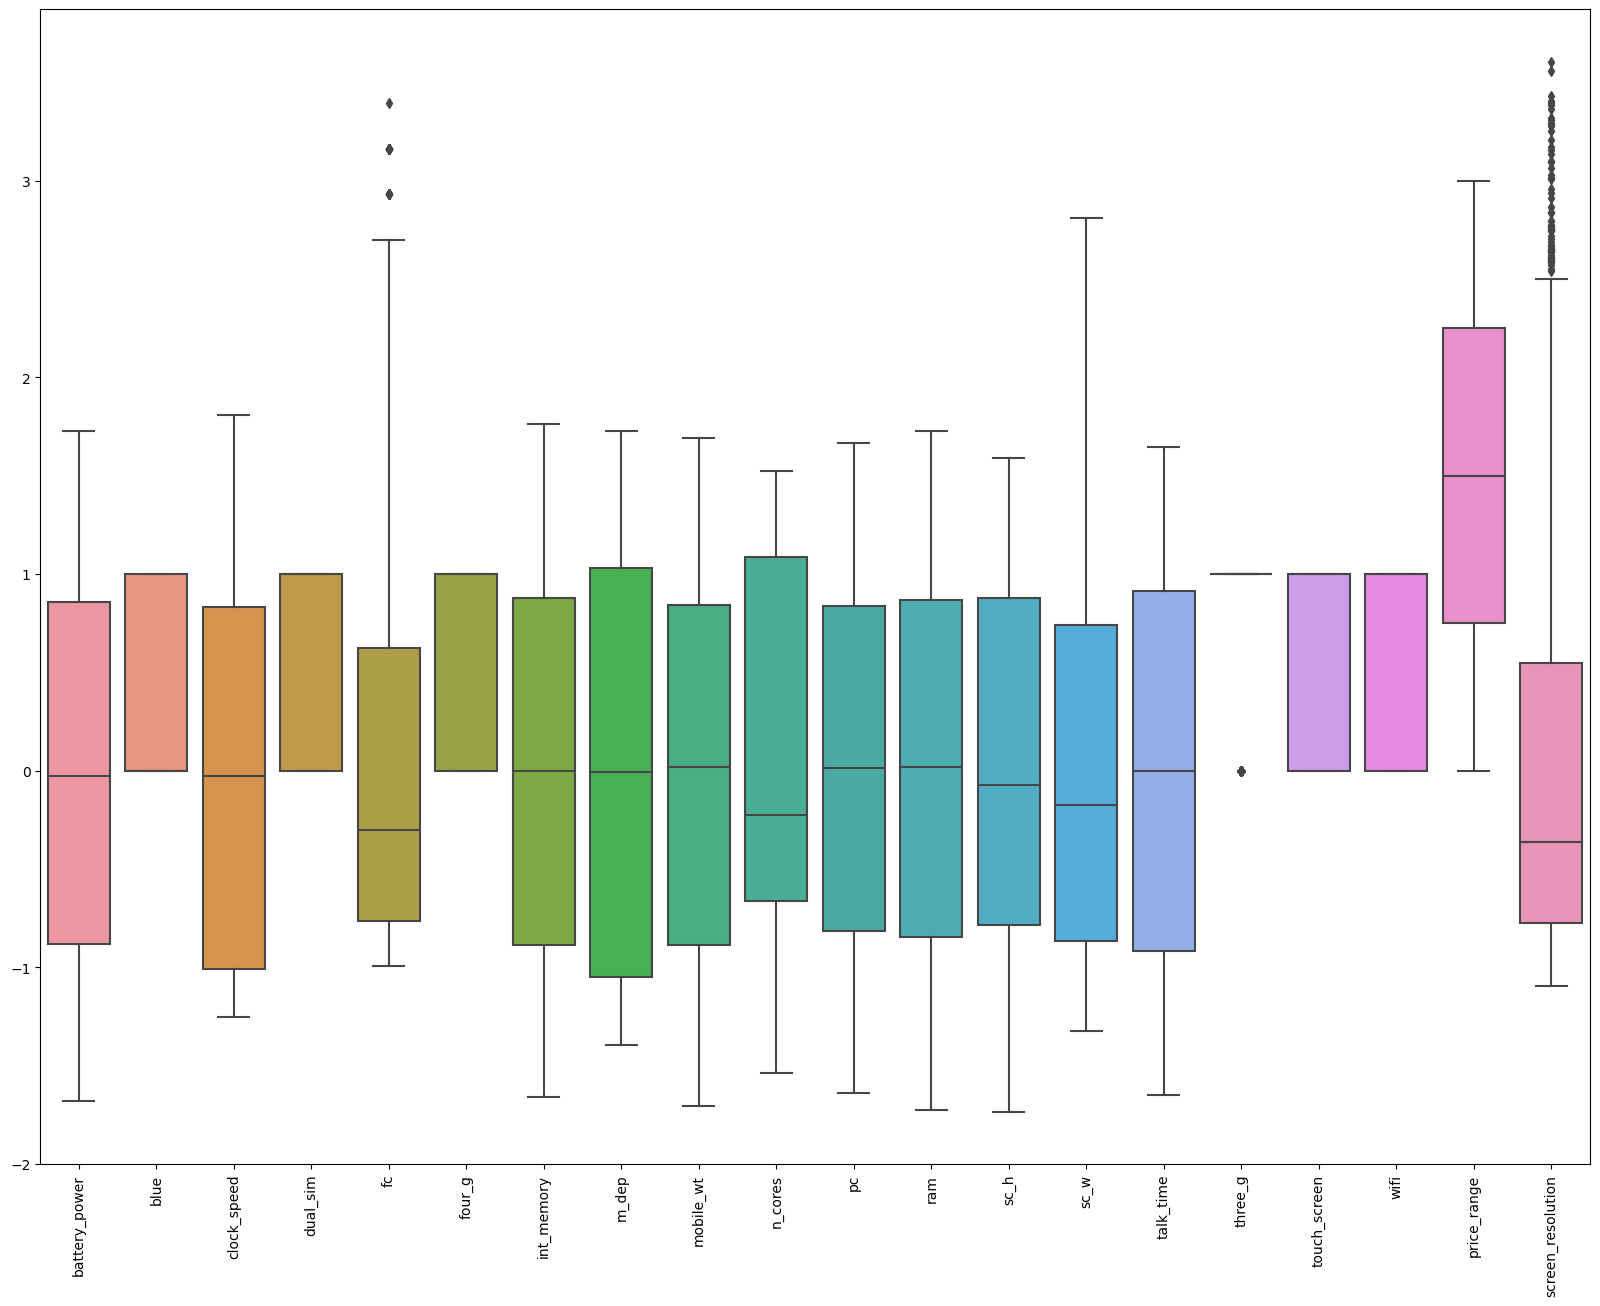

In [37]:
# Select specific columns for analysis
columns_to_analyze = df_imputed.columns

# Plot box plots for all numerical columns
plt.figure(figsize=(20, 15))
sns.boxplot(data=df_imputed[columns_to_analyze])
plt.xticks(rotation=90)
plt.show()

In [28]:
# Define features and target
X = df_imputed.drop('price_range', axis=1)
y = df_imputed['price_range']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [30]:
# Initialize the XGBoost model
model = XGBClassifier(random_state=42)

# Train the model
model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.75%


In [31]:
# Define a parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Best hyperparameters and corresponding accuracy
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2f}")

# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Accuracy with Best Model: {accuracy_best * 100:.2f}%')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy: 0.90
Accuracy with Best Model: 92.00%


In [32]:
# Feature selection using XGBoost feature importance
selector = SelectFromModel(best_model, prefit=True)
X_train_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test)

# Re-train the model with selected features
model_selected = XGBClassifier(random_state=42)
model_selected.fit(X_train_selected, y_train_smote)

# Evaluate with selected features
y_pred_selected = model_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f'Accuracy with Selected Features: {accuracy_selected * 100:.2f}%')

c:\Users\assem\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\assem\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Accuracy with Selected Features: 93.75%


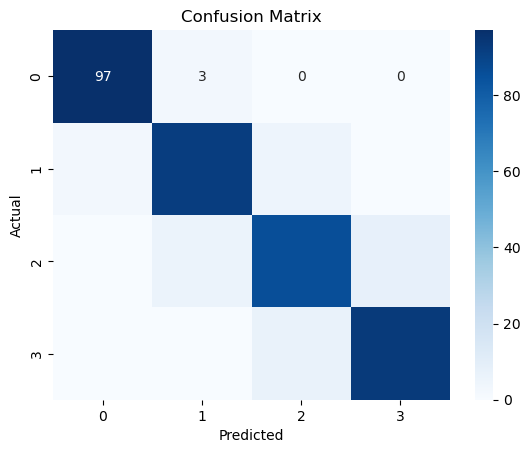

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       100
         1.0       0.91      0.92      0.92       100
         2.0       0.88      0.86      0.87       100
         3.0       0.92      0.93      0.93       100

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [33]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_best))

# ROC-AUC Curve and Precision-Recall Curve can be implemented for further evaluation

100%|===================| 1596/1600 [00:31<00:00]        

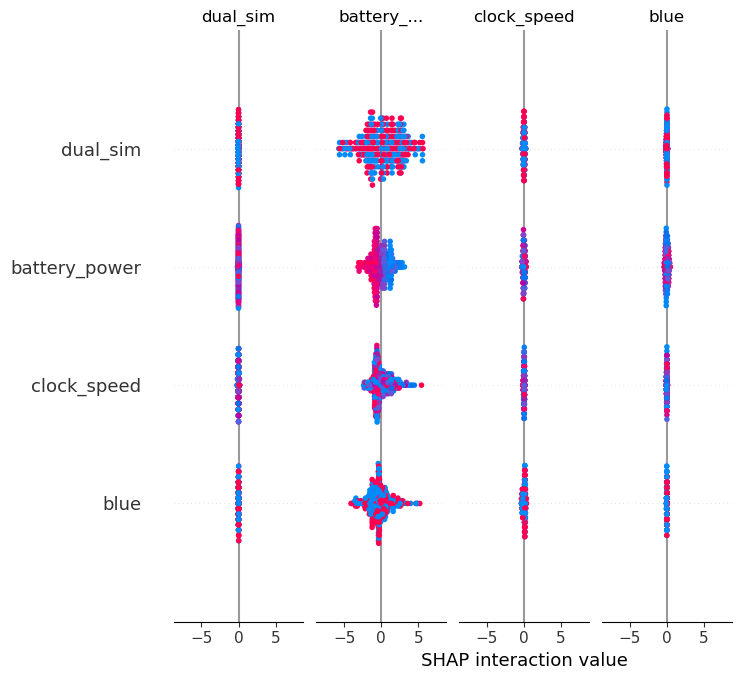

In [34]:
# Model explainability with SHAP
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [35]:
# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('model', XGBClassifier(random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_pipeline = pipeline.predict(X_test)

# Evaluate the pipeline model
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)
print(f'Pipeline Accuracy: {accuracy_pipeline * 100:.2f}%')

Pipeline Accuracy: 90.75%
